In [1]:
%cd Fair-Clustering-Codebase/
!dir

c:\Users\iason\Dev\CFC\Fair-Clustering-Codebase
 Volume in drive C is Windows
 Volume Serial Number is C0DD-1089

 Directory of c:\Users\iason\Dev\CFC\Fair-Clustering-Codebase

10/01/2024  06:18 ��    <DIR>          .
10/01/2024  06:21 ��    <DIR>          ..
10/01/2024  06:18 ��            28.183 accuracy_Office-31_SFD.png
10/01/2024  06:18 ��            25.881 balance_Office-31_SFD.png
10/01/2024  04:11 ��    <DIR>          Consensus-Fair-Clustering
10/01/2024  06:18 ��            24.565 entropy_Office-31_SFD.png
10/01/2024  04:11 ��    <DIR>          fair_clustering
10/01/2024  06:18 ��            24.066 nmi_Office-31_SFD.png
10/01/2024  06:18 ��             7.966 post_attack_res_Office-31_SFD.pkl
10/01/2024  06:18 ��             7.966 pre_attack_res_Office-31_SFD.pkl
10/01/2024  06:18 ��             7.966 random_attack_res_Office-31_SFD.pkl
10/01/2024  04:11 ��            28.880 s_DIGITS.npy
10/01/2024  04:11 ��               288 s_TOY.npy
10/01/2024  04:11 ��             8.752 U_i

In [2]:
import sys
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
import random
import kmedoids
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
from zoopt import Dimension, ValueType, Objective, Parameter, Opt, ExpOpt
# import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

from fair_clustering.eval.functions import * #[TO-DO] Write base class and derive metrics from it, temporary eval code

from fair_clustering.dataset import ExtendedYaleB, Office31, MNISTUSPS
from fair_clustering.algorithm import FairSpectral, FairKCenter, FairletDecomposition, ScalableFairletDecomposition

import matplotlib.pyplot as plt

# Set parameters related to dataset and get dataset

name = 'Office-31' #Choose between Office-31, MNIST_USPS, Yale, or DIGITS

if name == 'Office-31':
  dataset = Office31(exclude_domain='amazon', use_feature=True)
  X, y, s = dataset.data
elif name == 'MNIST_USPS':
  dataset = MNISTUSPS(download=True)
  X, y, s = dataset.data
elif name == 'Yale':
  dataset = ExtendedYaleB(download=True, resize=True)
  X, y, s = dataset.data
elif name == 'DIGITS':
  X, y, s = np.load('X_' + name + '.npy'), np.load('y_' + name + '.npy'), np.load('s_' + name + '.npy')

print(X.shape, y.shape, s.shape)

cl_algo = 'SFD' #Choose between FSC or SFD. For KFC run notebook locally (KFC is not available in Colab due to CPLEX being incompatible with Colab)


(1293, 2048) (1293,) (1293,)


In [5]:
print('Clustering Algorithm: ', cl_algo)
print('Dataset: ', name)
print('Number of Clusters: ', len(np.unique(y)))
print('Number of Data Points: ', len(y))
print('Number of Sensitive Features: ', len(np.unique(s)))
print('Number of Features: ', X.shape[1])

Clustering Algorithm:  SFD
Dataset:  Office-31
Number of Clusters:  31
Number of Data Points:  1293
Number of Sensitive Features:  2
Number of Features:  2048


In [6]:
# Fairness Attack
def attack_balance(solution):
  X_copy, s_copy = X.copy(), s.copy()
  flipped_labels = solution.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  if cl_algo == 'FSC':
    if name == 'MNIST_USPS':
      metr_str = 'manhattan'
    else:
      metr_str = 'euclidean'
    fair_clustering_algo = FairSpectral(n_clusters=n_clusters, num_neighbors=3, metric_str=metr_str, random_state=random_state)
  if cl_algo =='SFD':
    if name == 'DIGITS':      
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=1, random_state=random_state) 
    else:
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=2, random_state=random_state) 
  
  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)

  return bal


def attack_entropy(solution):
  X_copy, s_copy = X.copy(), s.copy()
  flipped_labels = solution.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  if cl_algo == 'FSC':
    if name == 'MNIST_USPS':
      metr_str = 'manhattan'
    else:
      metr_str = 'euclidean'
    fair_clustering_algo = FairSpectral(n_clusters=n_clusters, num_neighbors=3, metric_str=metr_str, random_state=random_state)
  if cl_algo =='SFD':
    if name == 'DIGITS':      
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=1, random_state=random_state) 
    else:
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=2, random_state=random_state) 
  
  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)

  ent = entropy(labels_sfd_eval, s_eval)

  return ent

def process_solution(sol):
  X_copy, s_copy, y_copy = X.copy(), s.copy(), y.copy()
  flipped_labels = sol.get_x()
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  if cl_algo == 'FSC':
    if name == 'MNIST_USPS':
      metr_str = 'manhattan'
    else:
      metr_str = 'euclidean'
    fair_clustering_algo = FairSpectral(n_clusters=n_clusters, num_neighbors=3, metric_str=metr_str, random_state=random_state)
  if cl_algo =='SFD':
    if name == 'DIGITS':      
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=1, random_state=random_state)
    else:
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=2, random_state=random_state) 
  
  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  y_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
    y_eval.append(y_copy[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)
  y_eval = np.array(y_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)
  ent = entropy(labels_sfd_eval, s_eval)
  accuracy = acc(y_eval, labels_sfd_eval)
  nmi_score = nmi(y_eval, labels_sfd_eval)

  return (bal, ent, accuracy, nmi_score)

def conduct_random_attack(size_sol):
  X_copy, s_copy, y_copy = X.copy(), s.copy(), y.copy()
  random.seed(None)
  flipped_labels = [random.randint(0,1) for _ in range(size_sol)]
  i = 0
  for idx in U_idx:
    s_copy[idx] = flipped_labels[i]
    i += 1

  if cl_algo == 'FSC':
    if name == 'MNIST_USPS':
      metr_str = 'manhattan'
    else:
      metr_str = 'euclidean'
    fair_clustering_algo = FairSpectral(n_clusters=n_clusters, num_neighbors=3, metric_str=metr_str, random_state=random_state)
  if cl_algo =='SFD':
    if name == 'DIGITS':      
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=1, random_state=random_state) #5,2
    else:
      fair_clustering_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=2, random_state=random_state) #5,2

  fair_clustering_algo.fit(X_copy, s_copy)
  labels_sfd = fair_clustering_algo.labels_

  s_eval = []
  X_eval = []
  labels_sfd_eval = []
  y_eval = []
  for idx in V_idx:
    s_eval.append(s_copy[idx])
    X_eval.append(X_copy[idx])
    labels_sfd_eval.append(labels_sfd[idx])
    y_eval.append(y_copy[idx])
  s_eval = np.array(s_eval)
  X_eval = np.array(X_eval)
  labels_sfd_eval = np.array(labels_sfd_eval)
  y_eval = np.array(y_eval)

  bal = balance(labels_sfd_eval, X_eval, s_eval)
  ent = entropy(labels_sfd_eval, s_eval)
  accuracy = acc(y_eval, labels_sfd_eval)
  nmi_score = nmi(y_eval, labels_sfd_eval)

  return (bal, ent, accuracy, nmi_score)


import numpy as np
n_clusters = len(np.unique(y))
print("# of clusters -> " + str(n_clusters))
seeds = [150, 1, 4200, 424242, 1947, 355, 256, 7500, 99999, 18]
n_trials = len(seeds)

U_idx_full, V_idx_full = np.load('U_idx_' + name + '.npy').tolist(), np.load('V_idx_' + name + '.npy').tolist()

pre_attack_res = {
    0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
}

post_attack_res = {
    0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
}

random_attack_res = {
    0 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    1 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    2 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    3 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    4 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    5 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    6 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
    7 : {'BALANCE': [], 'ENTROPY': [], 'ACC': [], 'NMI': []},
}

for percent, j in enumerate([int(0.125*len(U_idx_full)), int(0.25*len(U_idx_full)), int(0.375*len(U_idx_full)), int(0.5*len(U_idx_full)), int(0.625*len(U_idx_full)), int(0.75*len(U_idx_full)), int(0.875*len(U_idx_full)), int(len(U_idx_full))]):
  
  U_idx = U_idx_full[:j]
  V_idx = V_idx_full

  for trial_idx in range(n_trials):
    random_state = seeds[trial_idx]
    
    if cl_algo == 'FSC':
      if name == 'MNIST_USPS':
        metric_string = 'manhattan'
      else:
        metric_string = 'euclidean'
      fair_algo = FairSpectral(n_clusters=n_clusters, num_neighbors=3, metric_str = metric_string, random_state=random_state)
      fair_algo.fit(X, s)
      labels = fair_algo.labels_
    if cl_algo =='SFD':
      if name == 'DIGITS':      
        fair_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=1, random_state=random_state) #5,2
      else:
        fair_algo = ScalableFairletDecomposition(n_clusters=n_clusters, alpha=5, beta=2, random_state=random_state) #5,2
      fair_algo.fit(X, s)
      labels = fair_algo.labels_
    

    s_test = []
    X_test = []
    labels_test = []
    y_test = []
    for idx in V_idx:
      s_test.append(s[idx])
      X_test.append(X[idx])
      labels_test.append(labels[idx])
      y_test.append(y[idx])
    s_test = np.array(s_test)
    X_test = np.array(X_test)
    labels_test = np.array(labels_test)
    y_test = np.array(y_test)

    
    pre_attack_res[percent]['BALANCE'].append(balance(labels_test, X_test, s_test))
    pre_attack_res[percent]['ENTROPY'].append(entropy(labels_test, s_test))
    pre_attack_res[percent]['ACC'].append(acc(y_test, labels_test))
    pre_attack_res[percent]['NMI'].append(nmi(y_test, labels_test))
    
    dim_size = len(U_idx)
    dim = Dimension(dim_size, [[0, 1]]*dim_size, [False]*dim_size)

    if name == 'Office-31': #Only attack_balance
      obj = Objective(attack_balance, dim)
    elif name == 'MNIST_USPS' or name == 'DIGITS':
      if cl_algo == 'SFD':
        obj = Objective(attack_balance, dim)
      elif cl_algo == 'FSC':
        obj = Objective(attack_entropy, dim)
    elif name == 'Yale': #Only attack_entropy
      obj = Objective(attack_entropy, dim)
    
    solution = Opt.min(obj, Parameter(budget=20)) # 10 for FSC for MNIST_USPS and 50 for SFD for MNIST_USPS || 20 for FSC for Office-31 and 20 for SFD for Office-31 || 10 for FSC for Yale and 20 for SFD for Yale || 15 for FSC for DIGITS and 25 for SFD for DIGITS

    
    pa_bal, pa_ent, pa_acc, pa_nmi = process_solution(solution)
    post_attack_res[percent]['BALANCE'].append(pa_bal)
    post_attack_res[percent]['ENTROPY'].append(pa_ent)
    post_attack_res[percent]['ACC'].append(pa_acc)
    post_attack_res[percent]['NMI'].append(pa_nmi)

    r_bal, r_ent, r_acc, r_nmi = conduct_random_attack(dim_size)
    random_attack_res[percent]['BALANCE'].append(r_bal)
    random_attack_res[percent]['ENTROPY'].append(r_ent)
    random_attack_res[percent]['ACC'].append(r_acc)
    random_attack_res[percent]['NMI'].append(r_nmi)

# of clusters -> 31
[zoopt] expected remaining running time: 00:00:57
[zoopt] x: [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]
[zoopt] value: 0.1518194861092996
[zoopt] expected remaining running time: 00:00:57
[zoopt] x: [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]
[zoopt] value: 0.2949635730123535
[zoopt] expected remaining running time: 00:00:56
[zoopt] x: [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[zoopt] value: 0.26699288936463034
[zoopt] expected remaining running time: 00:00:56
[zoopt] x: [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
[zoopt] value: 0.1518194861092996
[zoopt] expected remaining running time: 00:00:56
[zoopt] x: [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[zoopt] value: 0.1518194861092996
[zoopt] expected remaining running time: 00:00:56
[zoopt] x: [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
[zoopt] value: 0.1518194861092996
[zoopt] expected remaining running time: 00:00:58
[zoopt] x: [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]
[zoop

Results for Office-31 with SFD algorithm
Pre-Attack Results
BALANCE -> 0.5464020334216646 0.5464020334216646 0.5464020334216646 0.5464020334216646 0.5464020334216646 0.5464020334216646 0.5464020334216646 0.5464020334216646 
ENTROPY -> 10.089681478164133 10.089681478164133 10.089681478164133 10.089681478164133 10.089681478164133 10.089681478164133 10.089681478164133 10.089681478164133 
ACC -> 0.8407216494845361 0.8407216494845361 0.8407216494845361 0.8407216494845361 0.8407216494845361 0.8407216494845361 0.8407216494845361 0.8407216494845361 
NMI -> 0.8875398288008564 0.8875398288008564 0.8875398288008564 0.8875398288008564 0.8875398288008564 0.8875398288008564 0.8875398288008564 0.8875398288008564 
Post-Attack Results
BALANCE -> 0.20025214581589196 0.19332329168672113 0.20821511267493392 0.18933349645416334 0.19416897915982662 0.1565529095196501 0.2462846971666249 0.2857780442383371 
ENTROPY -> 9.764075822922775 9.831709962446197 9.87191209646309 9.823642007682968 9.781707758961764 9.8

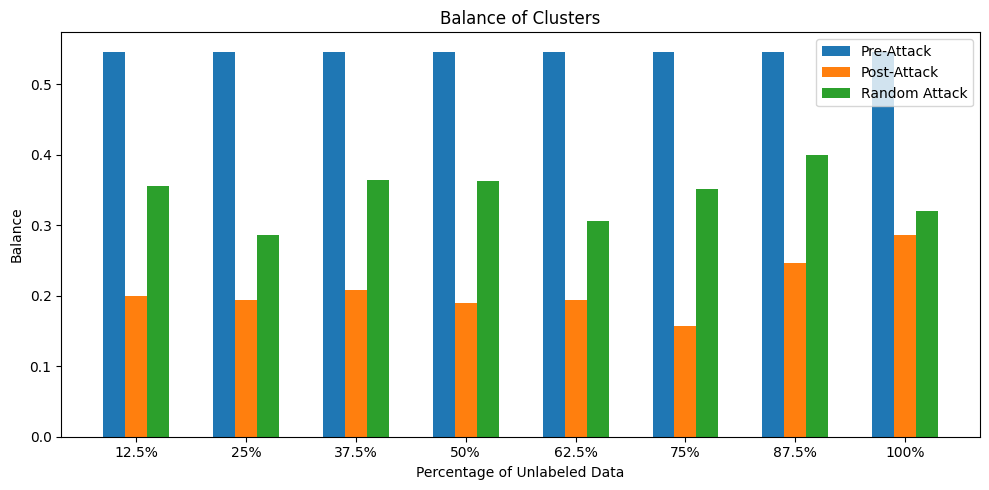

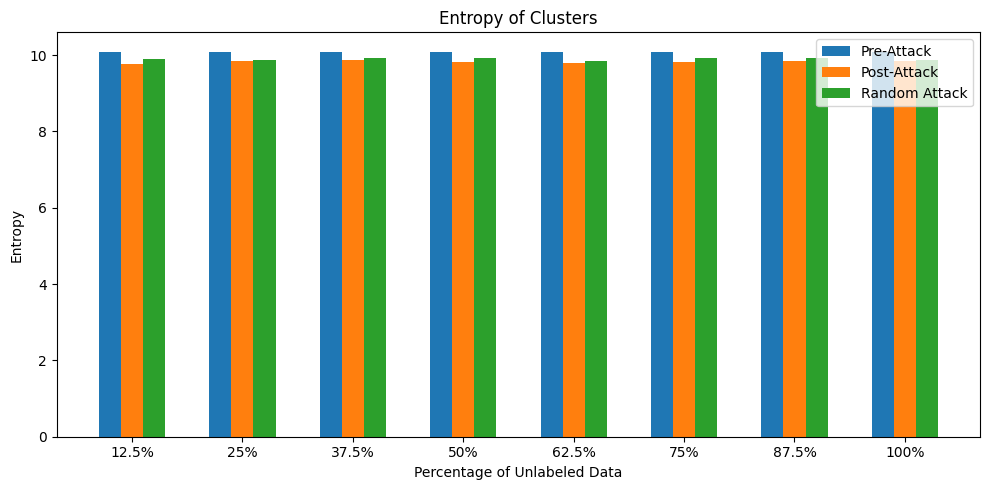

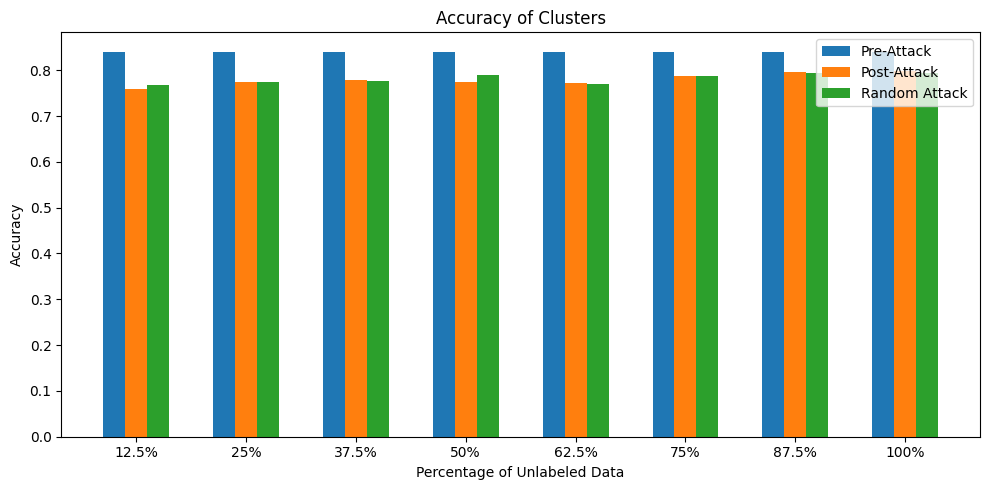

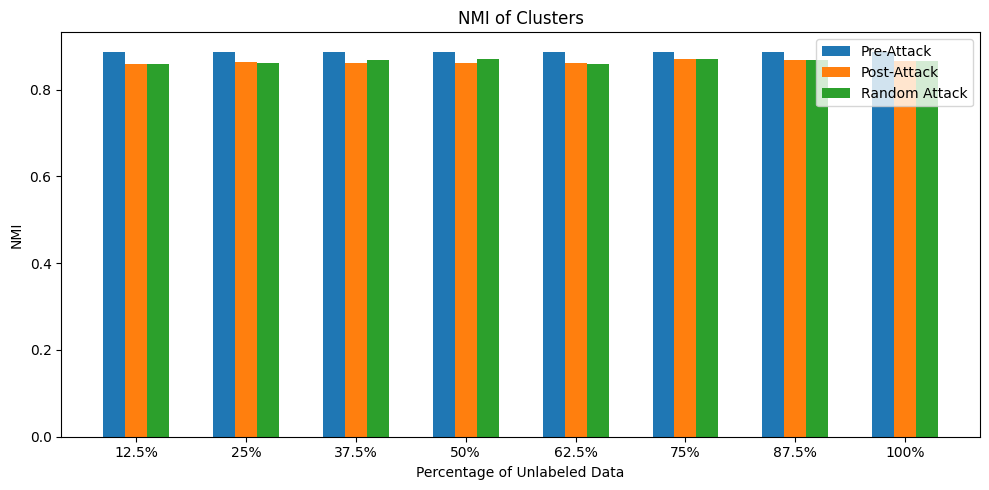

In [8]:
# Print results 
print("Results for " + name + " with " + cl_algo + " algorithm")
print("Pre-Attack Results")
print("BALANCE -> " + str(np.mean(pre_attack_res[0]['BALANCE'])) + " " + str(np.mean(pre_attack_res[1]['BALANCE'])) + " " + str(np.mean(pre_attack_res[2]['BALANCE'])) + " " + str(np.mean(pre_attack_res[3]['BALANCE'])) + " " + str(np.mean(pre_attack_res[4]['BALANCE'])) + " " + str(np.mean(pre_attack_res[5]['BALANCE'])) + " " + str(np.mean(pre_attack_res[6]['BALANCE'])) + " " + str(np.mean(pre_attack_res[7]['BALANCE'])) + " ")
print("ENTROPY -> " + str(np.mean(pre_attack_res[0]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[1]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[2]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[3]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[4]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[5]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[6]['ENTROPY'])) + " " + str(np.mean(pre_attack_res[7]['ENTROPY'])) + " ")
print("ACC -> " + str(np.mean(pre_attack_res[0]['ACC'])) + " " + str(np.mean(pre_attack_res[1]['ACC'])) + " " + str(np.mean(pre_attack_res[2]['ACC'])) + " " + str(np.mean(pre_attack_res[3]['ACC'])) + " " + str(np.mean(pre_attack_res[4]['ACC'])) + " " + str(np.mean(pre_attack_res[5]['ACC'])) + " " + str(np.mean(pre_attack_res[6]['ACC'])) + " " + str(np.mean(pre_attack_res[7]['ACC'])) + " ")
print("NMI -> " + str(np.mean(pre_attack_res[0]['NMI'])) + " " + str(np.mean(pre_attack_res[1]['NMI'])) + " " + str(np.mean(pre_attack_res[2]['NMI'])) + " " + str(np.mean(pre_attack_res[3]['NMI'])) + " " + str(np.mean(pre_attack_res[4]['NMI'])) + " " + str(np.mean(pre_attack_res[5]['NMI'])) + " " + str(np.mean(pre_attack_res[6]['NMI'])) + " " + str(np.mean(pre_attack_res[7]['NMI'])) + " ")

print("Post-Attack Results")
print("BALANCE -> " + str(np.mean(post_attack_res[0]['BALANCE'])) + " " + str(np.mean(post_attack_res[1]['BALANCE'])) + " " + str(np.mean(post_attack_res[2]['BALANCE'])) + " " + str(np.mean(post_attack_res[3]['BALANCE'])) + " " + str(np.mean(post_attack_res[4]['BALANCE'])) + " " + str(np.mean(post_attack_res[5]['BALANCE'])) + " " + str(np.mean(post_attack_res[6]['BALANCE'])) + " " + str(np.mean(post_attack_res[7]['BALANCE'])) + " ")
print("ENTROPY -> " + str(np.mean(post_attack_res[0]['ENTROPY'])) + " " + str(np.mean(post_attack_res[1]['ENTROPY'])) + " " + str(np.mean(post_attack_res[2]['ENTROPY'])) + " " + str(np.mean(post_attack_res[3]['ENTROPY'])) + " " + str(np.mean(post_attack_res[4]['ENTROPY'])) + " " + str(np.mean(post_attack_res[5]['ENTROPY'])) + " " + str(np.mean(post_attack_res[6]['ENTROPY'])) + " " + str(np.mean(post_attack_res[7]['ENTROPY'])) + " ")
print("ACC -> " + str(np.mean(post_attack_res[0]['ACC'])) + " " + str(np.mean(post_attack_res[1]['ACC'])) + " " + str(np.mean(post_attack_res[2]['ACC'])) + " " + str(np.mean(post_attack_res[3]['ACC'])) + " " + str(np.mean(post_attack_res[4]['ACC'])) + " " + str(np.mean(post_attack_res[5]['ACC'])) + " " + str(np.mean(post_attack_res[6]['ACC'])) + " " + str(np.mean(post_attack_res[7]['ACC'])) + " ")
print("NMI -> " + str(np.mean(post_attack_res[0]['NMI'])) + " " + str(np.mean(post_attack_res[1]['NMI'])) + " " + str(np.mean(post_attack_res[2]['NMI'])) + " " + str(np.mean(post_attack_res[3]['NMI'])) + " " + str(np.mean(post_attack_res[4]['NMI'])) + " " + str(np.mean(post_attack_res[5]['NMI'])) + " " + str(np.mean(post_attack_res[6]['NMI'])) + " " + str(np.mean(post_attack_res[7]['NMI'])) + " ")

print("Random Attack Results")
print("BALANCE -> " + str(np.mean(random_attack_res[0]['BALANCE'])) + " " + str(np.mean(random_attack_res[1]['BALANCE'])) + " " + str(np.mean(random_attack_res[2]['BALANCE'])) + " " + str(np.mean(random_attack_res[3]['BALANCE'])) + " " + str(np.mean(random_attack_res[4]['BALANCE'])) + " " + str(np.mean(random_attack_res[5]['BALANCE'])) + " " + str(np.mean(random_attack_res[6]['BALANCE'])) + " " + str(np.mean(random_attack_res[7]['BALANCE'])) + " ")
print("ENTROPY -> " + str(np.mean(random_attack_res[0]['ENTROPY'])) + " " + str(np.mean(random_attack_res[1]['ENTROPY'])) + " " + str(np.mean(random_attack_res[2]['ENTROPY'])) + " " + str(np.mean(random_attack_res[3]['ENTROPY'])) + " " + str(np.mean(random_attack_res[4]['ENTROPY'])) + " " + str(np.mean(random_attack_res[5]['ENTROPY'])) + " " + str(np.mean(random_attack_res[6]['ENTROPY'])) + " " + str(np.mean(random_attack_res[7]['ENTROPY'])) + " ")
print("ACC -> " + str(np.mean(random_attack_res[0]['ACC'])) + " " + str(np.mean(random_attack_res[1]['ACC'])) + " " + str(np.mean(random_attack_res[2]['ACC'])) + " " + str(np.mean(random_attack_res[3]['ACC'])) + " " + str(np.mean(random_attack_res[4]['ACC'])) + " " + str(np.mean(random_attack_res[5]['ACC'])) + " " + str(np.mean(random_attack_res[6]['ACC'])) + " " + str(np.mean(random_attack_res[7]['ACC'])) + " ")
print("NMI -> " + str(np.mean(random_attack_res[0]['NMI'])) + " " + str(np.mean(random_attack_res[1]['NMI'])) + " " + str(np.mean(random_attack_res[2]['NMI'])) + " " + str(np.mean(random_attack_res[3]['NMI'])) + " " + str(np.mean(random_attack_res[4]['NMI'])) + " " + str(np.mean(random_attack_res[5]['NMI'])) + " " + str(np.mean(random_attack_res[6]['NMI'])) + " " + str(np.mean(random_attack_res[7]['NMI'])) + " ")

# Plot results
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(8)
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, [np.mean(pre_attack_res[0]['BALANCE']), np.mean(pre_attack_res[1]['BALANCE']), np.mean(pre_attack_res[2]['BALANCE']), np.mean(pre_attack_res[3]['BALANCE']), np.mean(pre_attack_res[4]['BALANCE']), np.mean(pre_attack_res[5]['BALANCE']), np.mean(pre_attack_res[6]['BALANCE']), np.mean(pre_attack_res[7]['BALANCE'])], width, label='Pre-Attack')
rects2 = ax.bar(x, [np.mean(post_attack_res[0]['BALANCE']), np.mean(post_attack_res[1]['BALANCE']), np.mean(post_attack_res[2]['BALANCE']), np.mean(post_attack_res[3]['BALANCE']), np.mean(post_attack_res[4]['BALANCE']), np.mean(post_attack_res[5]['BALANCE']), np.mean(post_attack_res[6]['BALANCE']), np.mean(post_attack_res[7]['BALANCE'])], width, label='Post-Attack')
rects3 = ax.bar(x + width, [np.mean(random_attack_res[0]['BALANCE']), np.mean(random_attack_res[1]['BALANCE']), np.mean(random_attack_res[2]['BALANCE']), np.mean(random_attack_res[3]['BALANCE']), np.mean(random_attack_res[4]['BALANCE']), np.mean(random_attack_res[5]['BALANCE']), np.mean(random_attack_res[6]['BALANCE']), np.mean(random_attack_res[7]['BALANCE'])], width, label='Random Attack')

ax.set_ylabel('Balance')
ax.set_xlabel('Percentage of Unlabeled Data')
ax.set_title('Balance of Clusters')
ax.set_xticks(x)
ax.set_xticklabels(['12.5%', '25%', '37.5%', '50%', '62.5%', '75%', '87.5%', '100%'])
ax.legend()

fig.tight_layout()

plt.show()

fig.savefig('balance_' + name + '_' + cl_algo + '_new.png')

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, [np.mean(pre_attack_res[0]['ENTROPY']), np.mean(pre_attack_res[1]['ENTROPY']), np.mean(pre_attack_res[2]['ENTROPY']), np.mean(pre_attack_res[3]['ENTROPY']), np.mean(pre_attack_res[4]['ENTROPY']), np.mean(pre_attack_res[5]['ENTROPY']), np.mean(pre_attack_res[6]['ENTROPY']), np.mean(pre_attack_res[7]['ENTROPY'])], width, label='Pre-Attack')
rects2 = ax.bar(x, [np.mean(post_attack_res[0]['ENTROPY']), np.mean(post_attack_res[1]['ENTROPY']), np.mean(post_attack_res[2]['ENTROPY']), np.mean(post_attack_res[3]['ENTROPY']), np.mean(post_attack_res[4]['ENTROPY']), np.mean(post_attack_res[5]['ENTROPY']), np.mean(post_attack_res[6]['ENTROPY']), np.mean(post_attack_res[7]['ENTROPY'])], width, label='Post-Attack')
rects3 = ax.bar(x + width, [np.mean(random_attack_res[0]['ENTROPY']), np.mean(random_attack_res[1]['ENTROPY']), np.mean(random_attack_res[2]['ENTROPY']), np.mean(random_attack_res[3]['ENTROPY']), np.mean(random_attack_res[4]['ENTROPY']), np.mean(random_attack_res[5]['ENTROPY']), np.mean(random_attack_res[6]['ENTROPY']), np.mean(random_attack_res[7]['ENTROPY'])], width, label='Random Attack')

ax.set_ylabel('Entropy')
ax.set_xlabel('Percentage of Unlabeled Data')
ax.set_title('Entropy of Clusters')
ax.set_xticks(x)
ax.set_xticklabels(['12.5%', '25%', '37.5%', '50%', '62.5%', '75%', '87.5%', '100%'])
ax.legend()

fig.tight_layout()

plt.show()

fig.savefig('entropy_' + name + '_' + cl_algo + '_new.png')

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, [np.mean(pre_attack_res[0]['ACC']), np.mean(pre_attack_res[1]['ACC']), np.mean(pre_attack_res[2]['ACC']), np.mean(pre_attack_res[3]['ACC']), np.mean(pre_attack_res[4]['ACC']), np.mean(pre_attack_res[5]['ACC']), np.mean(pre_attack_res[6]['ACC']), np.mean(pre_attack_res[7]['ACC'])], width, label='Pre-Attack')
rects2 = ax.bar(x, [np.mean(post_attack_res[0]['ACC']), np.mean(post_attack_res[1]['ACC']), np.mean(post_attack_res[2]['ACC']), np.mean(post_attack_res[3]['ACC']), np.mean(post_attack_res[4]['ACC']), np.mean(post_attack_res[5]['ACC']), np.mean(post_attack_res[6]['ACC']), np.mean(post_attack_res[7]['ACC'])], width, label='Post-Attack')
rects3 = ax.bar(x + width, [np.mean(random_attack_res[0]['ACC']), np.mean(random_attack_res[1]['ACC']), np.mean(random_attack_res[2]['ACC']), np.mean(random_attack_res[3]['ACC']), np.mean(random_attack_res[4]['ACC']), np.mean(random_attack_res[5]['ACC']), np.mean(random_attack_res[6]['ACC']), np.mean(random_attack_res[7]['ACC'])], width, label='Random Attack')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Percentage of Unlabeled Data')
ax.set_title('Accuracy of Clusters')
ax.set_xticks(x)
ax.set_xticklabels(['12.5%', '25%', '37.5%', '50%', '62.5%', '75%', '87.5%', '100%'])
ax.legend()

fig.tight_layout()

plt.show()

fig.savefig('accuracy_' + name + '_' + cl_algo + '_new.png')

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width, [np.mean(pre_attack_res[0]['NMI']), np.mean(pre_attack_res[1]['NMI']), np.mean(pre_attack_res[2]['NMI']), np.mean(pre_attack_res[3]['NMI']), np.mean(pre_attack_res[4]['NMI']), np.mean(pre_attack_res[5]['NMI']), np.mean(pre_attack_res[6]['NMI']), np.mean(pre_attack_res[7]['NMI'])], width, label='Pre-Attack')
rects2 = ax.bar(x, [np.mean(post_attack_res[0]['NMI']), np.mean(post_attack_res[1]['NMI']), np.mean(post_attack_res[2]['NMI']), np.mean(post_attack_res[3]['NMI']), np.mean(post_attack_res[4]['NMI']), np.mean(post_attack_res[5]['NMI']), np.mean(post_attack_res[6]['NMI']), np.mean(post_attack_res[7]['NMI'])], width, label='Post-Attack')
rects3 = ax.bar(x + width, [np.mean(random_attack_res[0]['NMI']), np.mean(random_attack_res[1]['NMI']), np.mean(random_attack_res[2]['NMI']), np.mean(random_attack_res[3]['NMI']), np.mean(random_attack_res[4]['NMI']), np.mean(random_attack_res[5]['NMI']), np.mean(random_attack_res[6]['NMI']), np.mean(random_attack_res[7]['NMI'])], width, label='Random Attack')

ax.set_ylabel('NMI')
ax.set_xlabel('Percentage of Unlabeled Data')
ax.set_title('NMI of Clusters')
ax.set_xticks(x)
ax.set_xticklabels(['12.5%', '25%', '37.5%', '50%', '62.5%', '75%', '87.5%', '100%'])
ax.legend()

fig.tight_layout()

plt.show()


fig.savefig('nmi_' + name + '_' + cl_algo + '_new.png')

# Save results

import pickle

with open('pre_attack_res_' + name + '_' + cl_algo + '_new.pkl', 'wb') as f:
    pickle.dump(pre_attack_res, f)

with open('post_attack_res_' + name + '_' + cl_algo + '_new.pkl', 'wb') as f:
    pickle.dump(post_attack_res, f)

with open('random_attack_res_' + name + '_' + cl_algo + '_new.pkl', 'wb') as f:
    pickle.dump(random_attack_res, f)
